<a href="https://colab.research.google.com/github/davidfague/Model_Reduction_Methods/blob/main/Extracellular_Potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Cell Extracellular Potential

In [1]:
Reduce_cell=True

#### Download modules from Github

In [2]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 14.1 MB/s eta 0:00:00


In [3]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone https://github.com/davidfague/Model_Reduction_Methods.git

Cloning into 'Model_Reduction_Methods'...
remote: Enumerating objects: 1058, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 1058 (delta 157), reused 166 (delta 100), pack-reused 774
Receiving objects: 100% (1058/1058), 6.04 MiB | 18.90 MiB/s, done.
Resolving deltas: 100% (586/586), done.


In [5]:
%cd Model_Reduction_Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import recording functions
from stylized_module.recorder import Recorder

# #import analysis functions
# from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology,check_connectivity,generate_reduced_cell_seg_coords, create_seg_var_report

# from modeling_module.synapses import Synapse, Listed_Synapse
from modeling_module.cell_model import cell_model
import pandas as pd

/content/Model_Reduction_Methods


In [6]:
%cd expand_example

/content/Model_Reduction_Methods/expand_example


In [7]:
# compile the mod files
!nrnivmodl mod

/content/Model_Reduction_Methods/expand_example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mod/CaDynamics_E2.mod
 -> NMODL ../mod/Ca_HVA.mod
Translating CaDynamics_E2.mod into /content/Model_Reduction_Methods/expand_example/x86_64/CaDynamics_E2.c
 -> NMODL ../mod/Ca_LVAst.mod
Thread Safe
 -> NMODL ../mod/epsp.mod
Translating Ca_HVA.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_HVA.c
Thread Safe
Translating Ca_LVAst.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_LVAst.c
Thread Safe
 -> NMODL ../mod/Ih.mod
Translating epsp.mod into /content/Model_Reduction_Methods/expand_example/x86_64/epsp.c
 -> NMODL ../mod/Im.mod
Thread Safe
Tr

## Setup smiulation parameters

In [8]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from neuron import h
from scipy import signal
from IPython.display import display, clear_output
from ipywidgets import interactive_output, HBox, VBox, Label, Layout

from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline


h.load_file('stdrun.hoc')
# h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')


1.0

### Create a cell with reduced morphology

In [9]:
%ls

cell1.asc  example_expand.py  L5PCtemplate.hoc  x86_64/
Cell.hoc   L5PCbiophys3.hoc   mod/


In [10]:
# class Synapse(PointCurrent):
#     def __init__(self, cell, stim: h.NetStim, sec_index: int,
#                   syn_type: str = 'Exp2Syn', gmax: float = 0.01, loc: float = 0.5,
#                   record: bool = False):
#         super().__init__(cell, sec_index, loc)
#         self.stim = stim
#         self.gmax = gmax
#         self.__synapse_type(syn_type)
#         self.setup(record)

#     # PRIVATE METHODS
#     def __synapse_type(self, syn_type):
#         if syn_type == 'AlphaSynapse1':
#             # Reversal potential (mV); Synapse time constant (ms)
#             self.syn_params = {'e': 0., 'tau': 2.0}
#             # Variable name of maximum conductance (uS)
#             self.gmax_var = 'gmax'
#         elif syn_type == 'Exp2Syn':
#             self.syn_params = {'e': 0., 'tau1': 1.0, 'tau2': 3.0}
#             self.gmax_var = '_nc_weight'
#         else:
#             raise ValueError("Synpase type not defined.")
#         self.syn_type = syn_type
#         self.pp_obj = getattr(h, syn_type)(self.get_section()(self.loc))

#     def __setup_synapse(self):
#         self.syn = self.pp_obj
#         self.nc = h.NetCon(self.stim, self.syn, 1, 0, 1)
#         for key, value in self.syn_params.items():
#             setattr(self.syn, key, value)
#         self.set_gmax()

#     # PUBLIC METHODS
#     def setup(self, record: bool = False):
#         self.__setup_synapse()
#         if record:
#             self.setup_recorder()
    
#     def set_gmax(self, gmax: float = None):
#         if gmax is not None:
#             self.gmax = gmax
#         if self.gmax_var == '_nc_weight':
#             self.nc.weight[0] = self.gmax
#         else:
#             setattr(self.syn, self.gmax_var, self.gmax)

In [11]:

# # Load biophysical parameters from a json file
# filepath = os.path.join(paths.RESOURCES_ROOT, 'biophys_parameters/ReducedOrderL5_passive.json')
# with open(filepath) as f:
#     biophys_param = json.load(f)
# for genome in biophys_param['genome']:
#     if genome['value'] != "": genome['value'] = float(genome['value'])

h.load_file('L5PCbiophys3.hoc')

# # Load morphology parameters from a csv file
# geometry = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.load_file("import3d.hoc")


# Create a cell object
# cell = ReducedOrderL5CellPassiveDendrite(geometry=geometry, full_biophys=biophys_param)
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

synapses_list=[]
netcons_list=[]
if Reduce_cell==True:
  #reduce dendritic trees to cables
  reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

  # print('reduced cell n3d')
  # for sec in reduced_cell.dend:
  #   print(sec,sec.n3d())

  #expand cables to idealized dendritic trees
  sections_to_expand = [reduced_cell.hoc_model.apic[0]]
  furcations_x=[0.289004]
  nbranches=[4]
  reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                            synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
# print('dendritic cell n3d')
# for sec in reduced_dendritic_cell.all:
#   print(sec, sec.n3d())

In [12]:
# for sec in reduced_dendritic_cell.all:
#   print(sec.n3d())

In [13]:
# # try to fix dendrite's beginning location by looking at soma 3d coordinates:
# for sec in [reduced_dendritic_cell.soma]:
#   for i in range(sec.n3d()):
#     print(sec.x3d(i),sec.y3d(i),sec.z3d(i))

#soma has many 3d coordinates and current implementation begins dendrites at 3dcoordinates[1]

In [14]:
import random
#use defined cell_model class for generating 3d coordinates, recording ECP, 'book-keeping' etc...
random.seed(2)

# Create synaptic input
stim = h.NetStim()
frequency=15 #(hz)
spikeinterval = (1/frequency)*1000 #convert to T and milliseconds
stim.interval=spikeinterval
print(str(stim.interval))
stim.number = 3  # only one event
stim.start = 2.0  # delay (ms)

gmax = 1  # default synapse maximum conductance (uS)

if Reduce_cell==True:
  cell = cell_model(reduced_dendritic_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10)
  cell._nbranch=nbranches[0]
  # Add synapse to apical tufts
  tufts=[]
  for i,sec in enumerate(cell.apic):
    if i!=0: # do not add synapse to trunk
      tufts.append(sec)
      cell.add_synapse(stim, sec_index=cell.all.index(sec), gmax=gmax / cell._nbranch, loc=0.01) # need to adjust to only tufts
else:
  cell = cell_model(complex_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10)
  complex_branching_segment='L5PCtemplate[0].apic[36](0.961538)' #use to assign tuft synapses
  tufts=cell.apic[36].children()
  cell._nbranch=len(tufts) #determine branches starting from this branching point
  # Add synapse to apical tufts
  #indicate the complex branching segment # may have to observe complex cell first
  complex_branching_segment='L5PCtemplate[0].apic[36](0.961538)'
  for i,sec in enumerate(cell.apic[36].children()):
      cell.add_synapse(stim, sec_index=cell.all.index(sec), gmax=gmax / cell._nbranch, loc=0.01) # need to adjust to only tufts


# Add synapse to soma
cell.add_synapse(stim, sec_index=0, gmax=gmax)

# Add synapse to apical tufts

66.66666666666667
Generating 3D coordinates for:  L5PCtemplate[0].axon[0]
Generating 3D coordinates for:  L5PCtemplate[0].axon[1]


In [15]:
# # compare 
# for sec in cell.all:
#   for i in range(sec.n3d()):
#     print(sec.x3d(i))

In [16]:
# print(cell.seg_coords['pc'][0])

In [17]:
# dir(cell)

In [18]:
# make_reduced_seg_df(cell,"segments_expanded.csv") #need to improve make_reduced_seg_df
# expanded_segments_df=pd.read_csv("segments_expanded.csv")
# plot_morphology(expanded_segments_df,"expanded_morphology.svg")

In [19]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null 
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


In [20]:
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell, ReducedOrderL5CellPassiveDendrite
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

In [21]:
h.dt = params.DT  # time step
h.steps_per_ms = 1/h.dt
h.tstop = params.TSTOP  # simulation stop time

# Record time points
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)

# Record membrane voltage of all segments
V_rec = Recorder(cell.segments)

### Add electrodes (Neuropixel)
A probe with 384 electrodes [https://www.neuropixels.org/probe](https://www.neuropixels.org/probe). The coordinates of each electrode is a row in the array printed below.

In [22]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# coordinates (x, y, z) of electrodes
print(params.ELECTRODE_POSITION.shape)
print(params.ELECTRODE_POSITION)

(384, 3)
[[   -8. -1910.     0.]
 [   24. -1910.     0.]
 [  -24. -1890.     0.]
 ...
 [   24.  1890.     0.]
 [  -24.  1910.     0.]
 [    8.  1910.     0.]]


## Custom settings

Using the interactive tools below, you can change the position of the cell, and change the synapse strength and location on the cell.

#### Cell position parameters (x, y, z, alpha, h, phi)
Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate beta=arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

Use the sliders to change the 6 position parameters. Use the sliders 'elev' and 'azim' to change view of the 3D plot.

In [23]:
# for sec in cell.apic:
#   print(sec,sec.parentseg(), sec.n3d())

In [45]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import numpy as np
from typing import Union, Optional, List, Tuple

from cell_inference.utils.currents.ecp import move_position
from cell_inference.cells.stylizedcell import StylizedCell


def plot_morphology(sim: Optional = None, cellid: Optional[int] = 0, cell: Optional[StylizedCell] = None,
                    seg_coords: Optional[dict] = None, sec_nseg: Optional[List] = None,
                    type_id: Optional[List] = None, electrodes: Optional[np.ndarray] = None,
                    axes: Union[List[int], Tuple[int]] = [2, 0, 1], clr: Optional[List[str]] = None,
                    elev: int = 20, azim: int = 10, move_cell: Optional[Union[List,np.ndarray]] = None,
                    figsize: Optional[Tuple[float, float]] = None) -> Tuple[Figure, Axes]:
    """
    Plot morphology in 3D.

    sim: simulation object
    cellid: cell id in the simulation object. Default: 0
    cell: stylized cell object. Ignore sim and cellid if specified
    seg_coords: if not using sim or cell, a dictionary that includes dl, pc, r
    sec_nseg: if not using sim or cell, list of number of segments in each section
    type_id:  if not using sim or cell, list of the swc type id of each section/segment
    electrodes: electrode positions. Default: None, not shown.
    axes: sequence of axes to display in 3d plot axes.
        Default: [2,0,1] show z,x,y in 3d plot x,y,z axes, so y is upward.
    clr: list of colors for each type of section
    Return Figure object, Axes object
    """
    if sim is None and cell is None:
        if seg_coords is None or sec_nseg is None or type_id is None:
            raise ValueError("If not using 'Simulation', input arguments 'seg_coords', 'sec_nseg', 'type_id' are required.")
        if clr is None:
            clr = ('g', 'r', 'b', 'c')
        if move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        sec_id_in_seg = np.cumsum([0] + list(sec_nseg[:-1]))
        type_id = np.asarray(type_id) - 1
        if type_id.size != len(sec_nseg):
            type_id = type_id = type_id[sec_id_in_seg]
        type_id = type_id.tolist()
        label_idx = np.array([type_id.index(i) for i in range(4)])
        lb_odr = np.argsort(label_idx)
        label_idx = label_idx[lb_odr].tolist()
        sec_name = np.array(('soma','axon','dend','apic'))[lb_odr]
    else:
        if clr is None:
            clr = ('g', 'b', 'pink', 'purple', 'r', 'c')
        if cell is None:
            if move_cell is None:
                move_cell = sim.loc_param[cellid, 0]
            cell = sim.cells[cellid]
        elif move_cell is None:
            move_cell = [0., 0., 0., 0., 1., 0.]
        seg_coords = cell.seg_coords
        sec_id_in_seg = cell.sec_id_in_seg
        sec_nseg = []
        sec_name = []
        label_idx = []
        type_id = []
        for i, sec in enumerate(cell.all):
            sec_nseg.append(sec.nseg)
            name = sec.name().split('.')[-1]
            if name not in sec_name:
                sec_name.append(name)
                label_idx.append(i)
            type_id.append(sec_name.index(name))
    label_idx.append(-1)

    move_cell = np.asarray(move_cell).reshape((2, 3))
    dl = move_position([0., 0., 0.], move_cell[1], seg_coords['dl'])
    pc = move_position(move_cell[0], move_cell[1], seg_coords['pc'])
    xyz = 'xyz'
    box = np.vstack([np.full(3, np.inf), np.full(3, np.NINF)])
    if electrodes is not None:
        box[0, axes[0:2]] = np.amin(electrodes[:, axes[0:2]], axis=0)
        box[1, axes[0:2]] = np.amax(electrodes[:, axes[0:2]], axis=0)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    lb_ptr = 0
    for i, itype in enumerate(type_id):
        label = sec_name[lb_ptr] if i == label_idx[lb_ptr] else None
        if label is not None: lb_ptr += 1
        i0 = sec_id_in_seg[i]
        i1 = i0 + sec_nseg[i] - 1
        if sec_name[itype] == 'soma':
            p05 = (pc[i0] + pc[i1]) / 2
            ax.scatter(*[p05[j] for j in axes], c=clr[itype], s=20, label=label)
        else:
            p0 = pc[i0] - dl[i0] / 2
            p1 = pc[i1] + dl[i1] / 2
            ax.plot3D(*[(p0[j], p1[j]) for j in axes], color=clr[itype], label=label)
            box[0, :] = np.minimum(box[0, :], np.minimum(p0, p1))
            box[1, :] = np.maximum(box[1, :], np.maximum(p0, p1))
    ctr = np.mean(box, axis=0)
    r = np.amax(box[1, :] - box[0, :]) / 2
    box = np.vstack([ctr - r, ctr + r])
    if electrodes is not None:
        idx = np.logical_and(np.all(electrodes >= box[0, :], axis=1), np.all(electrodes <= box[1, :], axis=1))
        ax.scatter(*[(electrodes[idx, j], electrodes[idx, j]) for j in axes], color='orange', s=5, label='electrodes')
    box = box[:, axes]
    ax.auto_scale_xyz(*box.T)
    ax.view_init(elev, azim)
    # ax.legend(loc=1)
    ax.set_xlabel(xyz[axes[0]])
    ax.set_ylabel(xyz[axes[1]])
    ax.set_zlabel(xyz[axes[2]])
    plt.show()
    return fig, ax

In [46]:
loc_param_default = [0., 0., 80., 0., 1., 0.]  # Default position parameters
elev, azim = 10, 90  # Default view
# clr = ['g', 'yellow', 'orange', 'red', 'b', 'c', 'g', 'yellow', 'orange', 'red', 'pink', 'purple']  # section color
clr=[]
clr.extend(['black' for i in range(len([cell.soma]))]) # soma color
clr.extend(['red' for i in range(len(cell.dend))]) #dend colors
clr.extend(['purple' for i  in range(len(cell.axon))]) # axon colors
clr.extend(['blue']) #trunk color
clr.extend(['green' for i in range(len(cell.apic)-1)])  # branch colors

def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param,
                    elev=-elev, azim=-azim, figsize=(12, 8), clr = clr)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

set azim to -90 in order to focus on zy plane view. 2D plot is of xy plane.

#### Set synaptic input

Use the toggle button to switch synapse location between the soma and the proximal apical tuft dendrite. Use the slider 'Synapse maximal conductance' to change synapse strength.

In [25]:
w_syn_site = widgets.ToggleButtons(options=['Soma', 'Apical tuft (proximal)'])
w_gmax = widgets.FloatSlider(value=gmax, min=0, max=0.1, step=0.0002, readout_format='.4f')
display(VBox([w_syn_site, HBox([Label('Synapse maximal conductance (uS)'), w_gmax])]))

def set_synapse():
    soma_syn = w_syn_site.value == 'Soma'
    gmax_soma = w_gmax.value if soma_syn else 0
    gmax_tuft = 0 if soma_syn else w_gmax.value / cell._nbranch
    cell.synapse[0].set_gmax(gmax_soma)
    for syn in cell.synapse[1:]:
        syn.set_gmax(gmax_tuft)

In [26]:
# try to extract syn and gmax for plot information
print(w_gmax)
print(w_syn_site)

FloatSlider(value=0.1, max=0.1, readout_format='.4f', step=0.0002)
ToggleButtons(options=('Soma', 'Apical tuft (proximal)'), value='Soma')


In [27]:
# nseg = len(cell.segments)
# numTstep = int(h.tstop/h.dt)
# #since synapse list has combined synapses for computational efficiency, we must use NetCon list/unique spike trains to determine how many synapses were mapped
# NetCon_per_seg=[0]*nseg
# inh_NetCon_per_seg=[0]*nseg
# exc_NetCon_per_seg=[0]*nseg

# i_NMDA_bySeg= [[0] * (numTstep+1) ] * nseg # need to implement inmda recording

# v_rest=-60 #choose v_rest for categorizing inh/exc synapses

# for netcon in cell.netcons_list:
#   syn=netcon.syn()
#   if syn in synapses_list:
#     syn_seg_id=cell.segments.index(netcon.syn().get_segment())
#     if syn in cell.segments[syn_seg_id].point_processes():
#       NetCon_per_seg[syn_seg_id]+=1 # get synapses per segment
#       # NetCon_per_seg[syn_seg_id].append(netcon) # possible implementation if needing objects per segment
#       if syn.e > v_rest:
#         exc_NetCon_per_seg[syn_seg_id]+=1
#         # exc_NetCon_per_seg[syn_seg_id].append(netcon)# possible implementation if needing objects per segment
#       else:
#         inh_NetCon_per_seg[syn_seg_id]+=1
#         # inh_NetCon_per_seg[syn_seg_id].append(netcon)# possible implementation if needing objects per segment
#     else:
#       print("Warning: synapse not in designated segment's point processes")

#   else:
#     print("Warning: potentially deleted synapse:","|NetCon obj:",netcon,"|Synapse obj:",syn,"the NetCon's synapse is not in synapses_list. Check corresponding original cell's NetCon for location, etc.")

# #extract inmda from each segment # can be adjusted for gaba synapses or alpha synapses # only paired nmda/ampa synapses have vec_list[1]
# for synapse in cell.synapse:
#   try:
#     i_NMDA = np.array(synapse.rec_vec.vec_list[1])            #current = numpy array of NEURON Vector of current NMDA current at synapse j  
#     seg = synapse.get_segment_id()                            #seg = the segment in which synapse j is located 
#     #print('first try')
    
#     try:
#       i_NMDA_bySeg[seg] = i_NMDA_bySeg[seg] + i_NMDA    
#       #print('second try')                                           #Sum current over each segment
#     except: 
#       pass                                                                   #Except needed as some synpases do not have NMDA currrent and throw an error when called
#   except:
#     pass

In [28]:
%ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


In [29]:
cell.get_recorder_data() #also creates directory

Outputting data to  20.0outputcontrol_108nbranch_3NCs_0nsyn_642nseg


{'spikes': array([], dtype=float64),
 'ih_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'gNaTa_T_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'ina_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'icah_data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 

In [30]:
# output_folder_name=str(nbranches[0])+"nbranch_outputcontrol_"+str(int(len(cell.synapse)))+"nsyn"#+modelname  #include model name in output foler name (ex. original cell, reduced cell, expanded cell)
# #create output folder
# import os
# if not os.path.exists(output_folder_name):
#    os.makedirs(output_folder_name)

# print(output_folder_name)
# os.chdir(output_folder_name)

In [31]:
#save geometry file
# cell.geometry.to_csv('geometry.csv')

In [32]:
# #Should add "syn per seg" to seg data frame #also can try doing SynPerSeg/segL to have more of a density metric
# #can adjust functions to take df arguement
# def plotSynDensity(SynPerSeg,Type=str):
#   plt.figure(figsize=(4,10))
#   ax = plt.scatter(expanded_segments_df["Coord X"], expanded_segments_df["Coord Y"],c = SynPerSeg[0:nseg],cmap='jet',)
#   plt.vlines(110,400,500)
#   plt.text(0,450,'100 um')
#   plt.hlines(400,110,210)
#   plt.text(110,350,'100 um')
#   plt.xticks([])
#   plt.yticks([])
#   cbar = plt.colorbar()
#   cbar.ax.set_ylabel(Type+'Synapses per segment', rotation=270)

#   plt.box(False)
#   plt.savefig(Type+'_syns.svg')

# def plotSynDensityNoSoma(SynPerSeg,Type=str):
#   plt.figure(figsize=(4,10))
#   ax = plt.scatter(expanded_segments_df["Coord X"][1:], expanded_segments_df["Coord Y"][1:],c = SynPerSeg[1:nseg],cmap='jet',)
#   plt.vlines(110,400,500)
#   plt.text(0,450,'100 um')
#   plt.hlines(400,110,210)
#   plt.text(110,350,'100 um')
#   plt.xticks([])
#   plt.yticks([])
#   cbar = plt.colorbar()
#   cbar.ax.set_ylabel(Type+'Synapses per segment', rotation=270)

#   plt.box(False)
#   plt.savefig(Type+'_syns.svg')

# plotSynDensity(exc_NetCon_per_seg,'Exc') #len(cell.segments) #low number of segments makes plot look odd.

In [33]:
# plotSynDensity(inh_NetCon_per_seg,'Inh') # if soma has too many inh synapses the heatmap is not as interpretable

In [34]:
print(cell.seg_coords)

{'p0': array([[ 45.72555542,  18.34367752, -50.25      ],
       [ 66.62999725,  21.19000053, -52.40000153],
       [ 78.45999908,  19.29999924, -42.47000122],
       ...,
       [ -5.28000021,  72.70999908, -87.30000305],
       [ 45.72555923,  18.34367752, -50.25      ],
       [ 45.72555923, -11.65632248, -50.25      ]]), 'p1': array([[ 45.72555738,  18.34367764, -50.25      ],
       [ 66.92914899,  21.04089056, -51.99181296],
       [ 81.00648967,  20.13720301, -40.64734059],
       ...,
       [ -6.60813629,  72.50166421, -89.27267499],
       [ 45.72555923,   3.34367752, -50.25      ],
       [ 45.72555923, -26.65632248, -50.25      ]]), 'pc': array([[ 45.7255564 ,  18.34367758, -50.25      ],
       [ 66.77957312,  21.11544555, -52.19590724],
       [ 79.73324438,  19.71860112, -41.5586709 ],
       ...,
       [ -5.94406825,  72.60583165, -88.28633902],
       [ 45.72555923,  10.84367752, -50.25      ],
       [ 45.72555923, -19.15632248, -50.25      ]]), 'r': array([6.7357591

## Run simulation and plot results

Run the codes below to simulate and display results everytime after you change the parameters above.

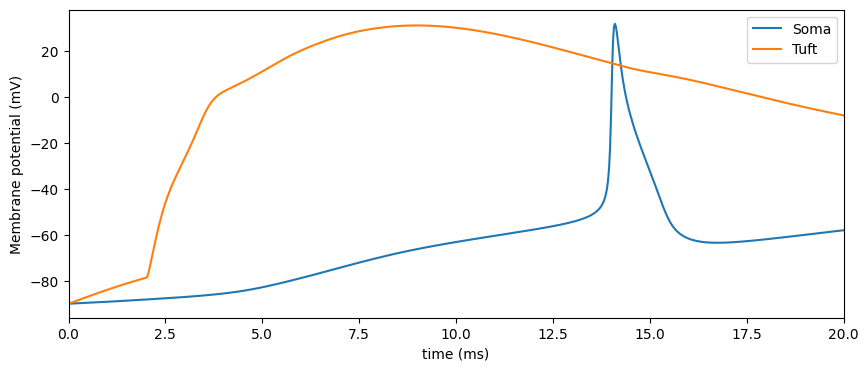

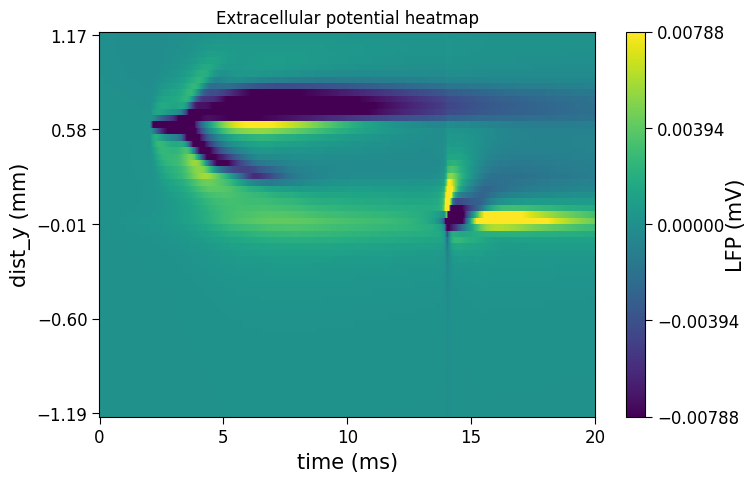

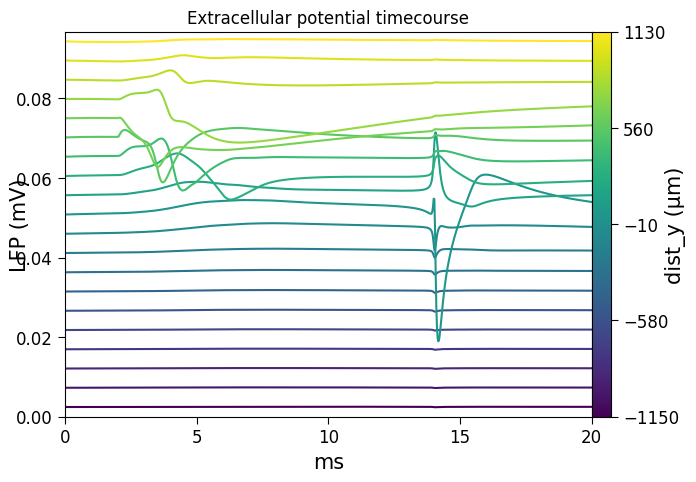

In [35]:
# Run simulation
set_synapse()
h.run()
# Get results
t = t_vec.as_numpy().copy()  # time array (ms)
# soma membrane potential
Vm = V_rec.as_numpy()
v_soma = Vm[cell.sec_id_in_seg[cell.all.index(cell.soma)]]
v_tfut = Vm[cell.sec_id_in_seg[cell.all.index(tufts[0])]]
# lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV

# Soma membrane potential
plt.figure(figsize=(10, 4))
plt.plot(t, v_soma, label='Soma')
plt.plot(t, v_tfut, label='Tuft')
plt.ylabel('Membrane potential (mV)')
plt.xlabel('time (ms)')
plt.xlim(t[[0, -1]])
plt.legend()
plt.savefig('Vm')

# Extracellular potential along y-axis
y_window = [-1200, 1200]  # select range of y coordinate for plotting
ylim = loc_param[1] + np.array(y_window)  # set range of y coordinate
max_idx = np.argmax(np.amax(np.abs(lfp), axis=0))  # find the electrode that records maximum magnitude
x_dist = elec_pos[max_idx, 0]  # x coordinate of the maximum magnitude electrode
e_idx = (elec_pos[:, 0]==x_dist) & (elec_pos[:, 1]>=ylim[0]) & (elec_pos[:, 1]<=ylim[1])  # selected electrode indices

fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5
plt.figure(figsize=(8, 5))
_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.title('Extracellular potential heatmap')
plt.savefig('ECP heatmap')
plt.figure(figsize=(8, 5))
_ = plot_lfp_traces(t, lfp[:, e_idx][:,1::3], electrodes=elec_pos[e_idx][1::3],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins, axes=plt.gca())
plt.title('Extracellular potential timecourse')
plt.savefig('ECP timecourse')

plt.show()

## Electrotonic distance

Neuron has a tool for electrotonic analysis [https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html](https://www.neuron.yale.edu/neuron/static/docs/zclass/zclass.html). It computes the electrotonic distance defined by attenuation, but the classical definition is [anatomical distance/length constant](https://www.neuron.yale.edu/neuron/static/docs/zclass/NIPS94/nipsfin.html).

The plot below shows the membrane potential timecourse at several locations on the cell. The electrotonic distance computed by Neuron of each location is also shown with both number and color. The distance should always be a positive value, but it is labeled negative for the basal dendrites and the axon intentionally so that it can be easily distinguished from the apical dendrites.

In [36]:
# geometry=cell.geometry

In [37]:
# for syn in cell.synapse:
#     syn.set_gmax(0)
# h.run()

# sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
# # sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all] # original
# # sec_type = [sec_type_swc[sec.name().split('.')[-1].split('[')[0]] for sec in cell.all] # possible alternative?
# sec_type = [sec_type_swc[sec.name()] for sec in cell.all]
# freq = 0 # Hz
# seg_prop, _, _ = measure_segment_distance(cell.soma , cell.all, sec_type, freq)

# select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
# select_seg = np.sum(np.array(select_seg), axis=1)
# # select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
# _ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
#                                   distance_type='elec_dist', n_dist=300,
#                                   select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
#                                   space=2., normalized_space=True, sort_by_dist=True,
                                  # figsize=(10, 10), fontsize=15, scalebar_size=50)

##Transfer Impedance



In [38]:
# import numpy as np
# from neuron import h
# import cmath

# def measure_segment_transfer_impedance(soma, section_list, sec_type, freq=0, extracellular_mechanism=True):
#     """
#     soma: soma section object
#     section_list: list of sections
#     sec_type: list of swc type id of sections
#     freq: frequency (Hz) at which electrotonic distance is evaluated
#     extracellular_mechanism: whether extracellular mechanism is used
#     """
#     seg_prop = {}
#     swc_type = []
#     seg_area = []
#     seg_dist = []
#     seg_length = []
#     elec_dist = [] #modulus part of polar form #should change names
#     elec_dist0 = [] #modulus of polar form #should change names
#     transfer_imps = [] #real part of rectangular form
#     transfer_imps0 = [] # real part of rectangular form

#     # set up distance origin
#     h.distance(0, soma(.5))
#     # set up electrotonic origin
#     zz = h.Impedance()
#     zz.loc(soma(.5))
#     if extracellular_mechanism:
#         zz.compute(freq + 1 / 9e9, 0) #*
#     else:
#         zz.compute(freq, 1)
#     # measure distance
#     for i, sec in enumerate(section_list):
#         if sec_type[i]==1:
#             transfer_imp=zz.transfer(sec(0.5/sec.nseg)) #*
#             transfer_phase=zz.transfer_phase(sec(0.5/sec.nseg)) #*
#             elec_dist0.append(transfer_imp) #*
#             rect_complex=cmath.rect(transfer_imp,transfer_phase)
#             transfer_imps.append(rect_complex.real) #*
#         else:
#             transfer_imp=zz.transfer(sec.parentseg()) #*
#             transfer_phase=zz.transfer_phase(sec.parentseg()) #*
#             elec_dist0.append(transfer_imp) #*
#             rect_complex=cmath.rect(transfer_imp, transfer_phase) #*
#             transfer_imps.append(rect_complex.real) #*
#         for j, seg in enumerate(sec):
#             swc_type.append(sec_type[i])
#             seg_area.append(seg.area())
#             seg_dist.append(h.distance(seg))
#             seg_length.append(sec.L/sec.nseg)
#             if j!=0:
#                 elec_dist0.append(elec_dist[-1])
#                 transfer_imps.append(transfer_imps0[-1])
#             elec_dist.append(zz.transfer(seg)) #*
#             transfer_imp=zz.transfer(seg) #*
#             transfer_phase=zz.transfer_phase(seg) #*
#             rect_complex=cmath.rect(transfer_imp,transfer_phase) #*
#             transfer_imps0.append(rect_complex.real) #*

#     seg_prop['swc_type'] = np.array(swc_type)
#     seg_prop['seg_area'] = np.array(seg_area)

#     # distance at endpoints of each segment
#     seg_prop['distance'] = np.expand_dims(seg_dist, 1) + np.expand_dims(seg_length, 1) / 2 * np.array([[-1, 1]])
#     # seg_prop['transfer_imp'] = np.sort(np.log(elec_dist0[0]) - np.log(np.column_stack([elec_dist0, elec_dist])), axis=1) #*
#     seg_prop['transfer_imp_mod'] = np.sort(elec_dist0[0] - np.column_stack([elec_dist0, elec_dist]), axis=1) #*
#     seg_prop['transfer_imp_real'] = np.sort(transfer_imps[0] - np.column_stack([transfer_imps, transfer_imps0]), axis=1) #*


#     # change sign of basal and axon types
#     idx = np.nonzero((seg_prop['swc_type']==2) | (seg_prop['swc_type']==3))[0]
#     seg_prop['distance'][idx] = -seg_prop['distance'][idx,::-1]
#     seg_prop['transfer_imp_mod'][idx] = -seg_prop['transfer_imp_mod'][idx,::-1] #*
#     seg_prop['transfer_imp_real'][idx] = -seg_prop['transfer_imp_real'][idx,::-1] #*
#     return seg_prop, zz.transfer(soma(.5)), zz.transfer_phase(soma(.5))


In [39]:
# #using modulus of polar form

# for syn in cell.synapse:
#     syn.set_gmax(0)
# h.run()

# sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
# sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
# freq = 0 # Hz
# seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

# select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
# select_seg = np.sum(np.array(select_seg), axis=1)
# # select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
# _ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
#                                   distance_type='transfer_imp_mod', n_dist=300,
#                                   select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
#                                   space=2., normalized_space=True, sort_by_dist=True,
#                                   figsize=(10, 10), fontsize=15, scalebar_size=50)

In [40]:
# #using real part of rectangular complex form

# for syn in cell.synapse:
#     syn.set_gmax(0)
# h.run()

# sec_type_swc = {sec['name']: sec['type'] for _, sec in geometry.iterrows()}
# sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in cell.all]
# freq = 0 # Hz
# seg_prop, _, _ = measure_segment_transfer_impedance(cell.soma , cell.all, sec_type, freq)

# select_seg = [[cell.sec_id_in_seg[sec[0]], cell.get_sec_by_id(sec[0]).nseg -1] for sec in cell.sec_id_lookup.values()]
# select_seg = np.sum(np.array(select_seg), axis=1)
# # select_seg = np.unique(np.cumsum(np.array(select_seg), axis=1).ravel())
# _ = plot_variable_with_morphology(cell.seg_coords, seg_prop, Vm, t=t, axes=['x', 'y'],
#                                   distance_type='transfer_imp_real', n_dist=300,
#                                   select_seg=select_seg, max_per_dist=1, varname='Membrane potential (mV)',
#                                   space=2., normalized_space=True, sort_by_dist=True,
#                                   figsize=(10, 10), fontsize=15, scalebar_size=50)

Transfer Impedance is a complex number

In [41]:
# polar_modulus=1
# polar_phase=3

# complex_rectangular_form=cmath.rect(polar_modulus, polar_phase)
# print(complex_rectangular_form)

In [42]:
# complex_rectangular_form.real